![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#==================================
# Importación de librerías
#==================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:

# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
#==================================
# Conversión de Boolean a int64 (como booleano no corría el código para el árbol de decisión
#==================================
X['M_Camry'] = pd.factorize(X.M_Camry)[0]
X['M_Camry4dr'] = pd.factorize(X.M_Camry4dr)[0]
X['M_CamryBase'] = pd.factorize(X.M_CamryBase)[0]
X['M_CamryL'] = pd.factorize(X.M_CamryL)[0]
X['M_CamryLE'] = pd.factorize(X.M_CamryLE)[0]
X['M_CamrySE'] = pd.factorize(X.M_CamrySE)[0]
X['M_CamryXLE'] = pd.factorize(X.M_CamryXLE)[0]
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
Index: 10495 entries, 7 to 399976
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Year         10495 non-null  int64
 1   Mileage      10495 non-null  int64
 2   M_Camry      10495 non-null  int64
 3   M_Camry4dr   10495 non-null  int64
 4   M_CamryBase  10495 non-null  int64
 5   M_CamryL     10495 non-null  int64
 6   M_CamryLE    10495 non-null  int64
 7   M_CamrySE    10495 non-null  int64
 8   M_CamryXLE   10495 non-null  int64
dtypes: int64(9)
memory usage: 1.1 MB


,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,2014,6480,0,0,0,0,0,0,0
11,2014,39972,0,0,0,1,1,0,0
167,2016,18989,0,0,0,1,0,1,0
225,2014,51330,0,0,0,0,0,0,0
270,2007,116065,0,1,0,1,0,0,0


In [ ]:
# Examinar la variable predictora 'Price' - estadísticas descriptivas básicas
print('Variable Predictora "Price" - Estadísticas Descriptivas Básicas')
print('-' * 40)
print(data['Price'].describe())

Variable Predictora "Price" - Estadísticas Descriptivas Básicas
----------------------------------------
count    10495.000000
mean     14538.403716
std       3922.420961
min       5002.000000
25%      11999.000000
50%      15000.000000
75%      16999.000000
max      32444.000000
Name: Price, dtype: float64


In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
#=======================================================
# Árbol de Decisión Manual para el problema de regresión
#=======================================================

# Calcular impureza basada en el error cuadrático medio (varianza de y).

def mean_squared_impurity(y):
    if len(y) == 0:
        return 0
    return np.var(y)


# Encontrar mejor división para el conjunto de datos basado en la reducción de MSE.
# Iterar sobre cada característica y calcular el MSE para posibles puntos de corte.

def best_split(X, y, num_pct=10):
    best_split = [None, None, float('inf')]  # j, split, gain
    for j in X.columns:
        # Intenta obtener puntos de corte a partir de los percentiles
        splits = np.percentile(X[j], np.linspace(0, 100, num_pct+1)[1:-1])
        for split in np.unique(splits):
            idx_l = X[j] < split
            idx_r = ~idx_l
            impurity_left = mean_squared_impurity(y[idx_l])
            impurity_right = mean_squared_impurity(y[idx_r])
            n_l, n_r = np.sum(idx_l), np.sum(idx_r)
            mse = (n_l * impurity_left + n_r * impurity_right) / (n_l + n_r)
            if mse < best_split[2]:
                best_split = [j, split, mse]
    return best_split


# Crear árbol de decisión. Divide los datos hasta que se cumpla alguna condición de parada.

def tree_grow(X, y, level=0, max_depth=None, num_pct=10):
    if len(y) == 0:
        return None
    if max_depth is not None and level >= max_depth:
        return {'y_pred': np.mean(y), 'level': level, 'n_samples': len(y)}

    j, split, mse = best_split(X, y, num_pct)
    if j is None:
        return {'y_pred': np.mean(y), 'level': level, 'n_samples': len(y)}

    # Crear subárboles de manera recursiva
    idx_l = X[j] < split
    idx_r = ~idx_l
    left_tree = tree_grow(X[idx_l], y[idx_l], level + 1, max_depth, num_pct)
    right_tree = tree_grow(X[idx_r], y[idx_r], level + 1, max_depth, num_pct)

    # Retornar nodo con información sobre la división y los subárboles
    return {
        'split_var': j,
        'split_val': split,
        'left': left_tree,
        'right': right_tree,
        'level': level,
        'n_samples': len(y),
        'mse': mse
    }

# Entrenar el árbol
tree = tree_grow(X_train, y_train, max_depth=3, num_pct=10)

# Predecir valores basado en el árbol construido. Navega el árbol de decisión para cada observación.

def tree_predict(X, tree):
    if tree is None:
        return np.array([])
    if 'split_var' not in tree:
        return np.full(X.shape[0], tree['y_pred'])

    idx_l = X[tree['split_var']] < tree['split_val']
    idx_r = ~idx_l
    preds = np.zeros(X.shape[0])
    if tree['left'] is not None:
        preds[idx_l] = tree_predict(X[idx_l], tree['left'])
    if tree['right'] is not None:
        preds[idx_r] = tree_predict(X[idx_r], tree['right'])

    return preds

# Calcular y mostrar las métricas de rendimiento RMSE y MAE del modelo

# Cálcular y evaluar el RMSE
predictions = tree_predict(X_test, tree)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE Árbol de Decisión Manual: {rmse:.4f}")

# Cálcular y evaluar el MAE
mae = mean_absolute_error(y_test, predictions)
print(f"MAE Árbol de Decisión Manual: {mae:.4f}")


RMSE Árbol de Decisión Manual: 1928.4011
MAE Árbol de Decisión Manual: 1454.1411


**Comparación de Resultados entre Árbol de Decisión Manual y la Escala y Distribución de Precios (Price)**


*   Media del Precio: $14,538.40

*   Desviación Estándar del Precio: $3,922.42

*   RMSE del Árbol de Decisión Manual: $1,928.40

*   MAE del Árbol de Decisión Manual: $1,454.14

**Análisis de Resultados Árbol de Decisión Manual:**
>>
- **Comparación de RMSE con la Media**: El RMSE del árbol de decisión es aproximadamente el 13.3% (1,928.40 / 14,538.40) de la media del precio, lo cual es un indicador de un buen ajuste general.
- **Comparación de RMSE con la Desviación Estándar del Precio**: Comparado con la desviación estándar, el RMSE es aproximadamente el 49.16% (1,928.40 / 3,922.42) de la desviación estándar. Esto sugiere que el modelo tiene una precisión aceptable, aunque hay margen de mejora.
- **Comparación del MAE con la Media del Precio**: Representa aproximadamente el 10% (1,454.14 / 14,538.40) de la media del precio, lo que indica que los errores típicos en las predicciones son razonablemente bajos en relación con el valor promedio del precio.

**Estos porcentajes sugieren que el modelo Árbol de Decisión Manual tiene un desempeño razonablemente bueno, aunque podría haber margen para mejorar, especialmente si podemos reducir el RMSE y el MAE más cerca o por debajo del 10% de la media del precio.**

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2

# Lista para almacenar los modelos de árbol de regresión
arboles = []

# Entrenamiento de los árboles de regresión en muestras bootstrap
for _ in range(10): # Repetir para crear 10 árboles
    # Generar índices de muestra bootstrap (con reemplazo)
    bootstrap_sample = np.random.choice(range(len(X_train)), size=len(X_train), replace=True)
    X_bootstrap = X_train.iloc[bootstrap_sample] # Subconjunto de X basado en índices bootstrap
    y_bootstrap = y_train.iloc[bootstrap_sample] # Subconjunto de y correspondiente
    arbol = DecisionTreeRegressor(random_state=2) # Crear un nuevo árbol de decisión
    arbol.fit(X_bootstrap, y_bootstrap) # Entrenar el árbol en la muestra bootstrap
    arboles.append(arbol) # Almacenar el árbol entrenado

# Realizar predicciones con cada árbol y promediarlas
predictions = np.mean([arbol.predict(X_test) for arbol in arboles], axis=0)

# Calcular y mostrar las métricas de rendimiento RMSE y MAE del modelo

# Cálcular y evaluar el RMSE
rmse = np.sqrt(mean_squared_error(predictions, y_test))
print(f"RMSE Bagging Manual:' {rmse:.4f}")

# Cálcular y evaluar el MAE
mae = mean_absolute_error(y_test, predictions)
print(f"MAE Bagging Manual: {mae:.4f}")

RMSE Bagging Manual:' 1779.7400
MAE Bagging Manual: 1325.2462


**Comparación de Resultados entre Bagging Manual y la Escala y Distribución de Precios (Price)**

*   Media del Precio: $14,538.40

*   Desviación Estándar del Precio: $3,922.42


**Análisis de Resultados Bagging Manual:**

>>
- **Comparación de RMSE con la Media:** El RMSE para el bagging es aproximadamente el 12% de la media del precio, sugiriendo una mayor precisión en las predicciones que el árbol de decisión manual.
- **Comparación de RMSE con la Desviación Estándar del Precio:** El RMSE es aproximadamente el 45% de la desviación estándar, mostrando una mejora en la precisión frente al árbol de decisión manual.
- **Comparación del MAE con la Media del Precio:** El MAE es aproximadamente el 9% de la media del precio, indicando una disminución en los errores típicos en comparación con el modelo de árbol de decisión.

---

**Comparación de resultados entre Bagging Manual vs Árbol de decisión:**
>>
- **RMSE:** El RMSE del bagging manual es menor que el del árbol de decisión manual, indicando un mejor rendimiento en términos de error cuadrático medio.
- **MAE:** El MAE del bagging también es menor, indicando menor error absoluto en las predicciones.

**Ambos modelos, el árbol de decisión manual y el bagging manual, muestran errores (RMSE y MAE) que son menos de la mitad de la desviación estándar de los precios, lo cual es indicativo de buenos modelos predictivos en este contexto.**

**El bagging manual supera al modelo de árbol de decisión tanto en RMSE como en MAE, destacando la eficacia del bagging para reducir la varianza y mejorar la precisión en las predicciones, haciendo que sea más robusto frente a la variabilidad de los precios de los automóviles.**

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3
mfeatures= int(np.log(X.shape[1]))
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, max_features=mfeatures, bootstrap=True, oob_score=True, random_state=1)

# Entrenar del modelo con set de entrenamiento y hacer predicciones en el set de test
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

# Calcular y mostrar las métricas de rendimiento RMSE y MAE del modelo

# Cálcular y evaluar el RMSE
rmse_bag=np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE Bagging con librería:{rmse_bag:.4f}")

# Cálcular y evaluar el MAE
mae_bag = mean_absolute_error(y_test, y_pred)
print(f"MAE Bagging con librería:{mae_bag:.4f}")

RMSE Bagging con librería:2671.0018
MAE Bagging con librería:2074.9172


**Comparación de Resultados entre Bagging con Librería y la Escala y Distribución de Precios (Price)**

* Media del Precio: $14,538.40

* Desviación Estándar del Precio: $3,922.42

* RMSE del Bagging con Librería: $2,671.00

* MAE del Bagging con Librería: $2,074.92

**Análisis de Resultados Bagging con Librería:**
>>
- **Comparación de RMSE con la Media del Precio:** El RMSE es aproximadamente el 18.4% de la media del precio (2,671 / 14,538.40). Este porcentaje indica que el error estándar de las predicciones es una fracción significativa de la media de los precios, lo que sugiere que las predicciones pueden variar considerablemente del valor real.
>>
- **Comparación de RMSE con la Desviación Estándar del Precio:** El RMSE es aproximadamente el 68.1% de la desviación estándar del precio (2,671 / 3,922.42). Este valor es relativamente alto, indicando que los errores del modelo representan una gran parte de la variabilidad total de los precios en los datos. Esto podría interpretarse como un indicador de que el modelo tiene espacio para mejora en términos de precisión.
>>
- **Comparación del MAE con la Media del Precio:** El MAE representa aproximadamente el 14.3% de la media del precio (2,074.92 / 14,538.40). Esto indica que, en promedio, las predicciones del modelo pueden desviarse de los valores reales por una cantidad que es una fracción significativa de la media de los precios.
>>
- **Comparación con los Modelos presentados en los puntos anteriores:**
En los puntos previos, se observó que otros modelos (como el Árbol de Decisión Manual y el Bagging Manual) presentaron un RMSE y MAE más bajos.

---

**Comparación de Resultados Bagging con Libreria vs Otros Modelos:**

**El modelo de Bagging con Librería muestra un error más alto tanto en términos de RMSE como de MAE en comparación con Bagging Manual y Árbol de Decisión Manual. Esto puede tener relación con la restricción impuesta por `max_features=log(n_features)`, que limita la cantidad de características consideradas en cada división, potencialmente aumentando el sesgo del modelo.**

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4

# Importar librería
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Imprimir la cantidad de features (características)
print('Cantidad de características:', X.shape[1])

# Definir el modelo de Random Forest
clf = RandomForestRegressor(n_estimators=50, max_features=None, random_state=1, n_jobs=-1)

# Entrenar el modelo con el conjunto de entrenamiento
clf.fit(X_train, y_train)

Cantidad de características: 9


RandomForestRegressor(max_features=None, n_estimators=50, n_jobs=-1,
                      random_state=1)

In [ ]:
# Hacer predicciones con el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular y mostrar las métricas de rendimiento RMSE y MAE del modelo

# Cálcular y evaluar el RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE Random Forest con Librería: {rmse_rf:.4f}")

# Cálcular y evaluar el MAE
mae_rf = mean_absolute_error(y_test, y_pred)
print(f"MAE Random Forest con Librería: {mae_rf:.4f}")

RMSE Random Forest con Librería: 1757.1327
MAE Random Forest con Librería: 1307.3469


**Comparación de Resultados entre Random Forest con Librería y la Escala y Distribución de Precios (Price)**

* Media del Precio: $14,538.40

* Desviación Estándar del Precio: $3,922.42

* RMSE del Random Forest con Librería: $1,757.13

* MAE del Random Forest con Librería: $1,307.34

**Análisis de Resultados Random Forest con Librería:**
>>
- **Comparación de RMSE con la Media del Precio:** El RMSE de 1757.13 es aproximadamente el 12% de la media del precio, lo cual es una mejora significativa en comparación con los modelos anteriores. Esto indica una buena precisión del modelo en relación con el nivel general de los precios.
>>
- **Comparación de RMSE con la Desviación Estándar del Precio:** El RMSE es aproximadamente el 44.8% de la desviación estándar, lo cual muestra que el modelo tiene un error sustancialmente menor que la variabilidad de los precios, indicando un buen ajuste del modelo a los datos.
>>
- **Comparación del MAE con la Media del Precio:** El MAE representa aproximadamente el 9.0% de la media del precio, lo que indica que los errores medios absolutos son bajos en comparación con el valor promedio de los precios.
>>

---

**Comparación de Resultados Random Forest con Libreria y Otros Modelos:**

**El modelo de Random Forest ha demostrado ser superior en términos de RMSE y MAE en comparación con las implementaciones manuales de árboles de decisión y bagging. La inclusión de características aleatorias y múltiples árboles en el modelo de Random Forest ayuda a mejorar la precisión y reducir el error, lo que lo convierte en una opción robusta para problemas de regresión como la predicción de precios de automóviles.**

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

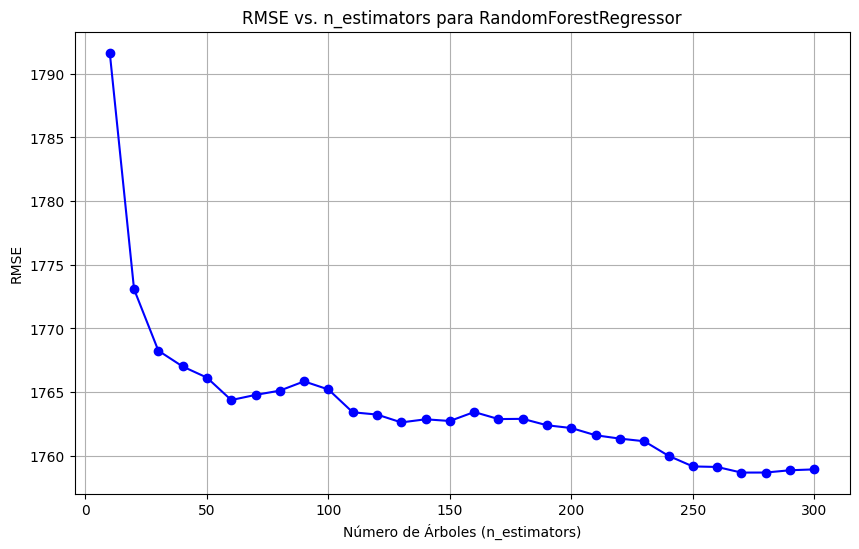

In [ ]:
# Celda 5

# Código para el Gráfico de RMSE vs. n_estimators:

rmse_values = []
n_estimators_options = np.arange(10, 310, 10)  # De 10 a 300 árboles

for n_estimators in n_estimators_options:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)  # Calcular el RMSE a partir del MSE
    rmse_values.append(rmse)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_options, rmse_values, marker='o', color='b', linestyle='-')
plt.title('RMSE vs. n_estimators para RandomForestRegressor')
plt.xlabel('Número de Árboles (n_estimators)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


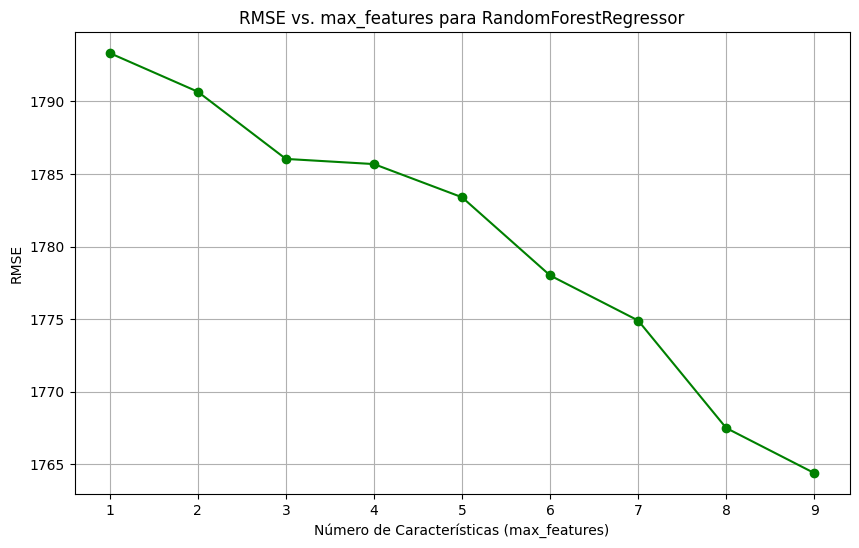

In [ ]:
# Código para el Gráfico de RMSE vs. max_features:

rmse_values = []
max_features_options = range(1, X_train.shape[1] + 1)  # De 1 a número total de características

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=60, max_features=max_features, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse_values.append(rmse)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(max_features_options, rmse_values, marker='o', color='g', linestyle='-')
plt.title('RMSE vs. max_features para RandomForestRegressor')
plt.xlabel('Número de Características (max_features)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


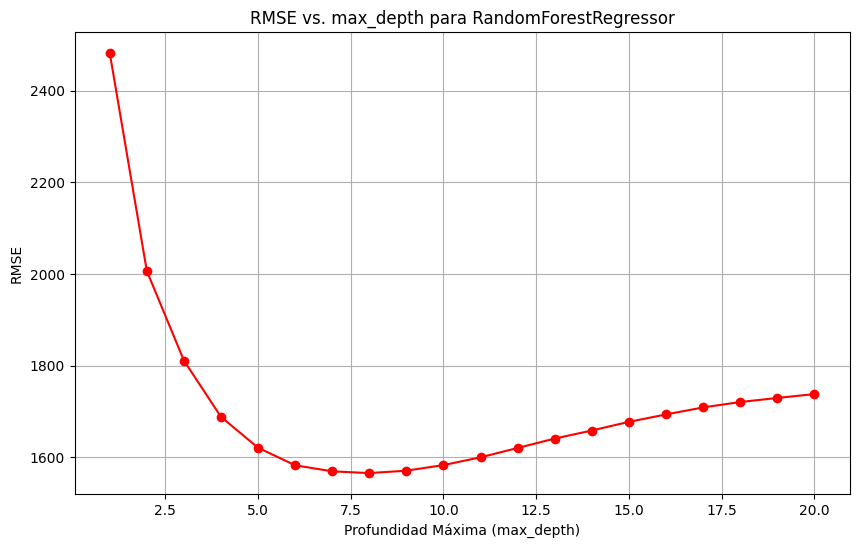

In [ ]:
# Código para el Gráfico de RMSE vs. max_depth:

rmse_values = []
max_depth_options = range(1, 21)  # Explorar profundidades de 1 a 20

for max_depth in max_depth_options:
    model = RandomForestRegressor(n_estimators=60, max_features='auto', max_depth=max_depth, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse_values.append(rmse)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(max_depth_options, rmse_values, marker='o', color='red', linestyle='-')
plt.title('RMSE vs. max_depth para RandomForestRegressor')
plt.xlabel('Profundidad Máxima (max_depth)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


In [ ]:
# Definir el modelo de Random Forest con los parámetros óptimos seleccionados
clf2 = RandomForestRegressor(n_estimators=270, max_features=9, max_depth=8, random_state=1, n_jobs=-1)

# Entrenar el modelo con el conjunto de entrenamiento
clf2.fit(X_train, y_train)


RandomForestRegressor(max_depth=8, max_features=9, n_estimators=270, n_jobs=-1,
                      random_state=1)

In [ ]:
# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'Características':X.columns, 'Importancia':clf2.feature_importances_}).sort_values('Importancia')

,Características,Importancia
4,M_CamryBase,0.000199
3,M_Camry4dr,0.000393
5,M_CamryL,0.000475
7,M_CamrySE,0.003063
2,M_Camry,0.007696
6,M_CamryLE,0.008106
8,M_CamryXLE,0.016960
1,Mileage,0.165590
0,Year,0.797519


In [ ]:
# Hacer predicciones con el conjunto de prueba
y_pred = clf2.predict(X_test)

# Calcular y mostrar las métricas de rendimiento RMSE y MAE del modelo

# Cálcular y evaluar el RMSE
rmse_rfc = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE Random Forest con Calibración: {rmse_rf:.4f}")

# Cálcular y evaluar el MAE
mae_rfc = mean_absolute_error(y_test, y_pred)
print(f"MAE Random Forest con Calibración: {mae_rf:.4f}")


RMSE Random Forest con Calibración: 1755.5910
MAE Random Forest con Calibración: 1307.0099


**Desempeño RMSE vs n_estimators**
El RMSE disminuye significativamente a medida que el número de árboles aumenta de 10 a 60, lo cual es típico, ya que tener más árboles suele mejorar el rendimiento del modelo. Sin embargo, después de aproximadamente 60 árboles, la mejora en el RMSE se vuelve menos pronunciada. Esto sugiere que, más allá de cierto punto, agregar más árboles no contribuye significativamente a la precisión del modelo.

**Desempeño RMSE vs max_features** El rendimiento del modelo mejora a medida que se consideran más características. El RMSE disminuye de manera consistente a medida que se aumenta el número de características hasta que alcanza un mínimo. Esto indica que permitir que cada árbol considere más características para cada división mejora el modelo. Sin embargo, es importante encontrar un equilibrio para evitar el sobreajuste.

**Desempeño RMSE vs max_depth**
A medida que la profundidad máxima aumenta de 2 a aproximadamente 8, el RMSE disminuye rápidamente, lo que significa que los árboles más profundos mejoran la precisión del modelo.

**Comparación de Resultados "Random Forest con Calibración": max_depth=8, max_features=9, n_estimators=270**

- **Comparación Random Forest con Calibración y Random Forest con Librería (Sin Calibración):** La diferencia en el RMSE entre los dos modelos, es una mejora marginal en el modelo con calibración. Esto indica que el proceso de calibración ha logrado una ligera mejora en la capacidad del modelo para predecir los precios con precisión.

- La diferencia en el MAE también es pequeña, a favor del modelo con calibración. Esto sugiere que el modelo calibrado, en promedio, tiene errores ligeramente menores en sus predicciones en comparación con el modelo de librería.

- Al observar las diferencias mínimas en las métricas de rendimiento, podemos concluir que la calibración realizada, que incluyó ajustar el número de árboles a 270, profundidad máxima a 8, y el número de características a 9, ha tenido un impacto muy sutil en el desempeño del modelo.


- **Comparación con Bagging y Árbol de Decisión Individual:** Los valores de RMSE y MAE son menores en el Random Forest calibrado en comparación con los modelos de Bagging y el Árbol de Decisión individual, esto sugiere que la calibración de parámetros ha ayudado a que Random Forest supere a los otros métodos de ensamble y modelos individuales en precisión de predicción.

**Conclusiones:**

**A pesar de que la calibración de parámetros suele conducir a mejoras en el rendimiento del modelo, en este caso, la calibración ha producido una mejora muy pequeña. Esto podría sugerir que el modelo ya estaba relativamente bien ajustado con los parámetros por defecto.**

**Tanto el Random Forest con librería como el calibrado muestran un buen rendimiento, con errores de predicción que se mantienen en niveles razonables en relación con los precios de los automóviles. Sin embargo, cabe la posibilidad de que una calibración más detallada o la inclusión de otros métodos.**


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6

# Importar librería
from xgboost import XGBRegressor

# Definir de modelo XGBRegressor
clfXGBoost = XGBRegressor()
print(clfXGBoost)
print('-' * 60)

# Entrenamiento (fit) del modelo XGBRegressor
clfXGBoost.fit(X_train, y_train)

# Predicción en el conjunto de test
y_pred = clfXGBoost.predict(X_test)

# Cálculo de métricas de desempeño
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular el Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calcular el Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Imprimir los resultados
print(f'RMSE XGBoost con Librería: {np.sqrt(mse):.4f}')
print(f'MAE XGBoost con Librería: {mae:.4f}')


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
------------------------------------------------------------
RMSE XGBoost con Librería: 1605.2355
MAE XGBoost con Librería: 1185.2273


**Análisis de XGBoost con Librería:**

- Media del Precio: $14,538.40

- Desviación Estándar del Precio: $3,922.42

- RMSE XGBoost con Librería: $1,605.24

- MAE XGBoost con Librería: $1,185.23

**Comparación de XGBoost con Librería y la Escala y Distribución de Precios (Price):**

- **Comparación de RMSE con la Media:**
El RMSE del modelo XGBoost es aproximadamente el 11.04% (1605.24 / 14,538.40) de la media del precio, lo cual es indicativo de un muy buen ajuste general.

- **Comparación de RMSE con la Desviación Estándar:**
Comparado con la desviación estándar, el RMSE es aproximadamente el 40.91% (1605.24 / 3,922.42) de la desviación estándar, lo cual es bastante bueno y sugiere que el modelo tiene una precisión notablemente alta.

- **Comparación del MAE con la Media del Precio:**
El MAE representa aproximadamente el 8.15% (1185.23 / 14,538.40) de la media del precio, lo que indica que los errores típicos en las predicciones son sustancialmente bajos en relación con el valor promedio del precio.

**Comparación entre XGBoost con Librería vs Otros Modelos:**

- **XGBoost vs Random Forest con Librería:**
El modelo XGBoost mejora tanto en RMSE como en MAE comparado con Random Forest sin calibración (1605.24 vs 1757.13 en RMSE y 1185.23 vs 1307.35 en MAE), lo que indica que XGBoost tiene un mejor rendimiento predictivo.

- **XGBoost vs Random Forest con Calibración:**
XGBoost también supera al Random Forest calibrado, presentando menores errores tanto en RMSE como en MAE (1605.24 vs 1755.59 en RMSE y 1185.23 vs 1307.01 en MAE), reflejando una mejor precisión general.

- **XGBoost vs Bagging Manual:**
XGBoost muestra un desempeño superior al Bagging Manual (1605.24 vs 1779.74 en RMSE y 1185.23 vs 1325.25 en MAE), sugiriendo que es más efectivo en manejar la variabilidad de los datos y en hacer predicciones precisas.

**Conclusiones:**

El modelo XGBoost con librería demuestra ser el más efectivo en términos de RMSE y MAE cuando se compara con Random Forest (tanto con y sin calibración) y Bagging Manual, lo que resalta las fortalezas de XGBoost, como su habilidad para manejar una amplia gama de tipos de datos, su eficiencia en el cálculo y su efectividad en la prevención del sobreajuste. Estos factores hacen de XGBoost una elección robusta para el conjunto de datos actual y una herramienta valiosa para problemas de predicción de precios.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# Definir el modelo base
xgb = XGBRegressor()

# Definir los rangos de los parámetros para la calibración
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.5, 1],
    'colsample_bytree': [0.3, 0.7, 1.0]
}

# Definir el scorer basado en el RMSE
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring=scorer)

# Entrenar el modelo con la búsqueda de cuadrícula
grid_search.fit(X_train, y_train)

# Ver los mejores parámetros encontrados
print('Mejores parámetros:', grid_search.best_params_)

# Predicción con el mejor modelo encontrado
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Calcular y mostrar las métricas de rendimiento con el modelo calibrado
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f'RMSE XGBoost con Calibración: {rmse:.4f}')
print(f'MAE XGBoost con Calibración: {mae:.4f}')


Mejores parámetros: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1}
RMSE XGBoost con Calibración: 1552.3148
MAE XGBoost con Calibración: 1139.6590


**Análisis de XGBoost con Calibración:**

- Media del Precio: $14,538.40

- Desviación Estándar del Precio: $3,922.42

- RMSE XGBoost con Calibración: $1,552.31

- MAE XGBoost con Calibración: $1,139.66

**Comparación de XGBoost con Calibración y la Escala y Distribución de Precios (Price):**

- **Comparación de RMSE con la Media:**
El RMSE del modelo XGBoost con calibración es aproximadamente el 10.68% (1,552.31 / 14,538.40) de la media del precio, indicando un ajuste excelente general.

- **Comparación de RMSE con la Desviación Estándar:**
Comparado con la desviación estándar, el RMSE es aproximadamente el 39.58% (1,552.31 / 3,922.42), mostrando una precisión destacada y sugiriendo que el modelo gestiona bien la variabilidad en los datos.

- **Comparación del MAE con la Media del Precio:**
El MAE representa aproximadamente el 7.83% (1,139.66 / 14,538.40) de la media del precio, indicando que los errores típicos en las predicciones son bastante bajos en relación con el valor promedio del precio de automóviles.

** Análisis de los Mejores Parámetros:**
- **colsample_bytree: 0.7** - Este parámetro con valor de 0.7 significa que cada árbol en el ensamble usa el 70% de las características disponibles al azar. Limitar el número de características puede ayudar a hacer que el modelo sea más robusto al evitar sobreajustes y mejorar la generalización.

- **gamma: 0** - El gamma con valor de 0 indica que no hay penalización adicional por realizar particiones adicionales en un nodo del árbol, lo cual permite que el modelo crezca libremente siempre que cada división resulte en una mejora en la pureza del nodo.

- **learning_rate: 0.1** - Un learning rate de 0.1 es un equilibrio entre un aprendizaje efectivo y la prevención del sobreajuste. Es suficientemente rápido para converger bien, pero no tan alto como para saltarse soluciones óptimas.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.


## Celda 8

**Resultados Obtenido al ejecutar los modelos  (random forest y XGBoost)**

**Random Forest con Librería**
* RMSE: 1757.1327 - MAE: 1307.3469

**Random Forest con Calibración**
* RMSE: 1755.5910 - MAE: 1307.0099

>>Observación: Ligera mejora en ambas métricas respecto al modelo sin calibración.

**XGBoost con Librería**
* RMSE: 1605.2355 - MAE: 1185.2273

>>Observación: Presenta un mejor rendimiento en comparación con Random Forest, tanto en RMSE como en MAE.

**XGBoost con Calibración**
* RMSE: 1552.3148 - MAE: 1139.6590

>>Observación: Muestra la mayor mejora y el mejor rendimiento entre todos los modelos evaluados.


**Análisis y Comentarios:**

- **Mejor Modelo:** El XGBoost con Calibración es el modelo con mejor desempeño, demostrando los valores más bajos tanto de RMSE como de MAE. Esta mejora se atribuye a la calibración efectiva de parámetros como el learning rate, gamma y colsample_bytree, que optimizan la capacidad del modelo para manejar la variabilidad de los datos y mejorar la precisión de las predicciones.

- **Ventajas de XGBoost con Calibración:** Reducción del Sobreajuste: Gracias a parámetros ajustados como el gamma, que ayuda a regularizar el modelo al penalizar las divisiones adicionales del árbol.
Eficiencia en el Manejo de Características: El uso óptimo de 'colsample_bytree' permite que el modelo considere un subconjunto de características en cada split, mejorando la generalización del modelo.
Aprendizaje Eficaz: El ajuste del 'learning_rate' permite un aprendizaje más eficiente y estable, evitando cambios bruscos en las estimaciones del modelo que podrían llevar a un sobreajuste.

- **Menor Desempeño:** El Random Forest sin Calibración muestra el menor desempeño, aunque con minima diferencia con respecto a Random Forest Calibrado, lo que puede deberse a la falta de optimización de parámetros como max_features y n_estimators, que son cruciales para ajustar la complejidad y capacidad del modelo.

- **Desventajas de Random Forest sin Calibración:**
Generalización relativamente pobre o deficiente: Sin una calibración adecuada, Random Forest puede sufrir de sobreajuste, especialmente en conjuntos de datos con mucha variabilidad.
Rendimiento Predictivo: Debido a la ausencia de optimización en los parámetros, puede no lograr capturar todas las complejidades del conjunto de datos.

**Conclusión General:**
El XGBoost con Calibración emerge como el modelo más robusto y efectivo para el problema en cuestión, superando a los modelos de Random Forest tanto calibrados como no calibrados. Esto destaca la importancia de una adecuada calibración de parámetros en el rendimiento general de los modelos de machine learning, particularmente en algoritmos complejos como XGBoost.



<Figure size 5000x1000 with 0 Axes>

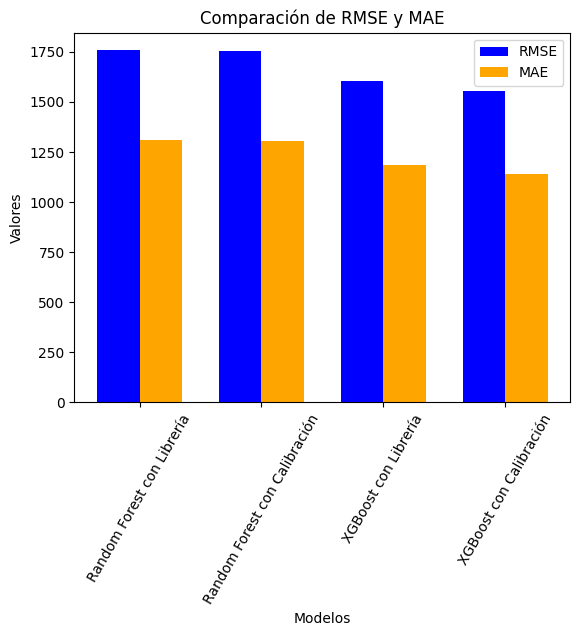

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de RMSE y MAE
labels = ['Random Forest con Librería', 'Random Forest con Calibración', 'XGBoost con Librería', 'XGBoost con Calibración']
rmse = [1757.1327, 1755.5910, 1605.2355, 1552.3148]
mae = [1307.3469, 1307.0099, 1185.2273, 1139.6590]

# Posiciones de las barras
x = np.arange(len(labels))

# Ancho de las barras
width = 0.35

# Crear gráfico de barras
plt.figure(figsize=(50, 10))
fig, ax = plt.subplots()
bars_rmse = ax.bar(x - width / 2, rmse, width, label='RMSE', color='b')
bars_mae = ax.bar(x + width / 2, mae, width, label='MAE', color='orange')

# Añadir etiquetas a las barras
ax.set_xlabel('Modelos')
ax.set_ylabel('Valores')
ax.set_title('Comparación de RMSE y MAE')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=60)

# Mostrar el gráfico
plt.show()
